In [17]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.status()

  Activating project at `~/Documents/Carnegie-Mellon/Chatterjee Group/Programming/heisenberg-model/Biquadratic.jl/analysis`


Status `~/Documents/Carnegie-Mellon/Chatterjee Group/Programming/heisenberg-model/Biquadratic.jl/analysis/Project.toml`
⌃ [13f3f980] CairoMakie v0.15.4
  [780c37f4] Carlo v0.2.5
⌃ [a93c6f00] DataFrames v1.7.0
  [f67ccb44] HDF5 v0.17.2
⌃ [033835bb] JLD2 v0.5.15
  [ebeed567] PeriodicArrays v0.1.0 `../../../PeriodicArrays.jl#main`
  [90137ffa] StaticArrays v1.9.14
Info Packages marked with ⌃ have new versions available and may be upgradable.


In [18]:
using CairoMakie
using Carlo.ResultTools
using DataFrames
using HDF5
using JLD2
using LinearAlgebra
using StaticArrays

In [19]:
# Parse DataFrame from ResultTools into more readily useable form
cleandata(filepath::AbstractString) = select(
    DataFrame(ResultTools.dataframe(filepath)),
    [:T, :K, :Lx, :Ly, :Dxπ, :Dyπ, :P, :J_s],
)

cleandata (generic function with 1 method)

In [20]:
function generatePlot(data::AbstractDataFrame, x, y; fig=Figure(), fig_pos=(1,1),
                      title, xlabel, ylabel, line=false, label="")
    fig[fig_pos...] = Axis(fig; title, xlabel, ylabel)

    vals = getfield.(data[:, y], :val)
    errs = getfield.(data[:, y], :err)
    scatter!(data[:, x], vals; label)
    if line
        lines!(data[:, x], vals)
    end
    errorbars!(data[:, x], vals, errs)

    return fig
end

function generatePlot(data::GroupedDataFrame, x, y; fig=Figure(), fig_pos=(1,1),
                      title, xlabel, ylabel, line=false)
    fig = Figure()
    fig[fig_pos...] = Axis(fig; title, xlabel, ylabel)

    for key in keys(data)
        group = data[key]
        vals = getfield.(group[:, y], :val)
        errs = getfield.(group[:, y], :err)
        scatter!(group[:, x], vals, label="$(NamedTuple(key))")
        if line
            lines!(group[:, x], vals)
        end
        errorbars!(group[:, x], vals, errs)
    end

    axislegend()

    return fig
end

generatePlot (generic function with 2 methods)

In [21]:
jobname = "small-sys"
data = groupby(cleandata("../jobs/" * jobname * ".results.json"), [:K])

Row,T,K,Lx,Ly,Dxπ,Dyπ,P,J_s
,Float64,Float64,Int64,Int64,Measurem…,Measurem…,Measurem…,Measurem…
1,0.01,-0.005,20,20,0.9881±0.00072,0.98809±0.00072,0.0646±0.0079,0.0648±0.0079
2,0.05,-0.005,20,20,0.9354±0.0028,0.9354±0.0028,0.172±0.013,0.173±0.013
3,0.1,-0.005,20,20,0.8686±0.0061,0.8686±0.0061,0.227±0.019,0.235±0.02
4,0.125,-0.005,20,20,0.823±0.019,0.823±0.019,0.238±0.036,0.259±0.035
5,0.15,-0.005,20,20,0.8041±0.01,0.804±0.01,0.223±0.02,0.266±0.021
6,0.175,-0.005,20,20,0.7813±0.0089,0.7813±0.0089,0.193±0.011,0.264±0.019
7,0.2,-0.005,20,20,0.715±0.017,0.715±0.017,0.251±0.026,0.336±0.026
8,0.225,-0.005,20,20,0.709±0.01,0.709±0.01,0.248±0.02,0.304±0.017
9,0.25,-0.005,20,20,0.611±0.028,0.61±0.028,0.258±0.022,0.383±0.028


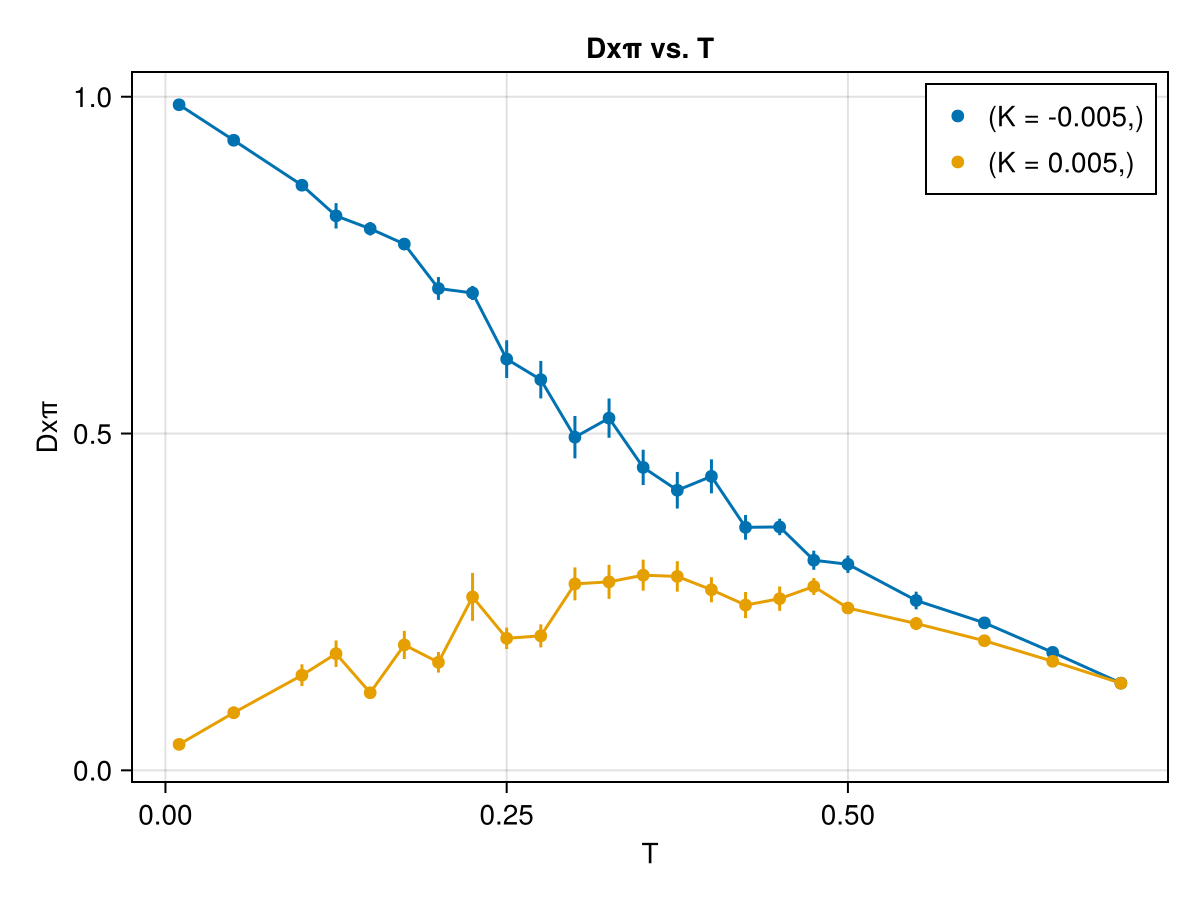

In [22]:
generatePlot(
    data, :T, :Dxπ;
    title="Dxπ vs. T",
    xlabel="T",
    ylabel="Dxπ",
    line=true
)

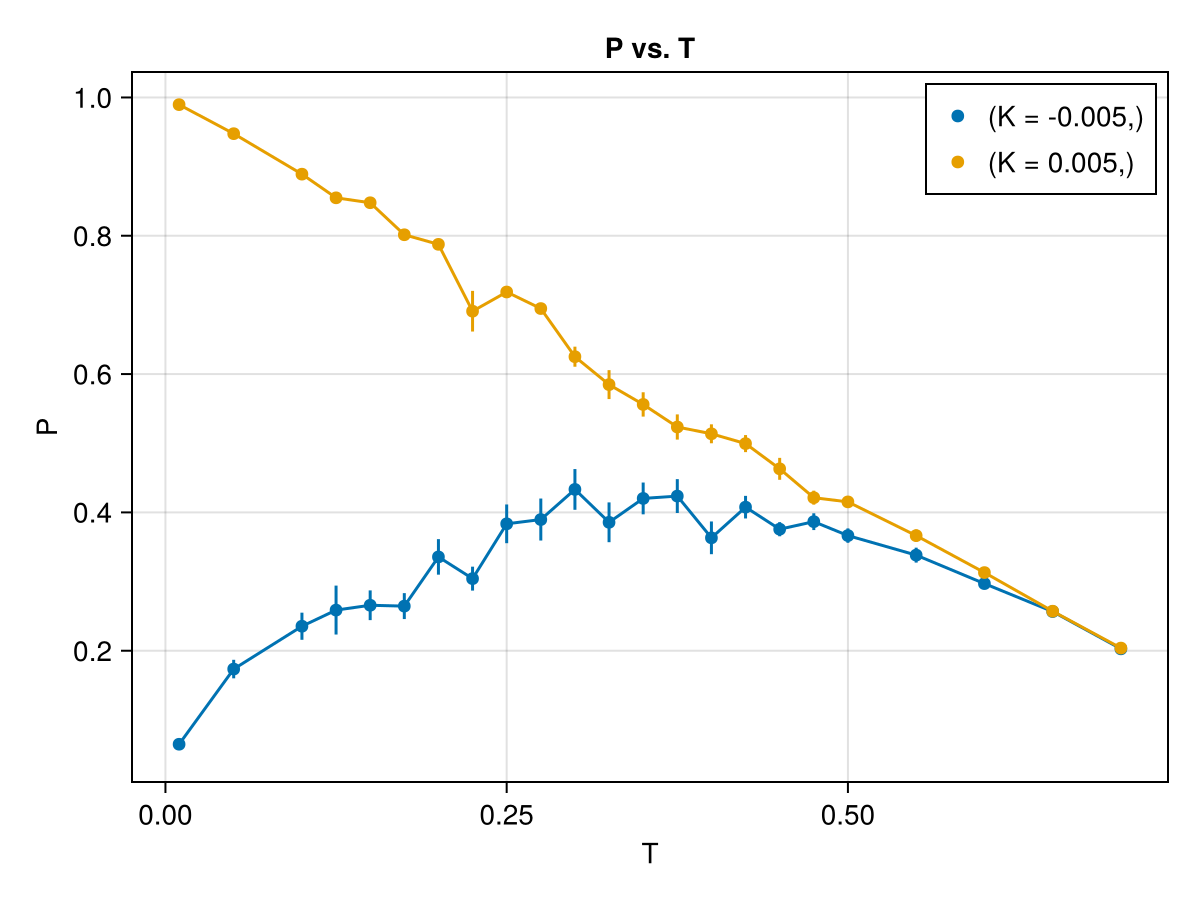

In [23]:
generatePlot(
    data, :T, :J_s;
    title="P vs. T",
    xlabel="T",
    ylabel="P",
    line=true
)

In [24]:
ungrouped_data = cleandata("../jobs/$jobname.results.json")

Row,T,K,Lx,Ly,Dxπ,Dyπ,P,J_s
,Float64,Float64,Int64,Int64,Measurem…,Measurem…,Measurem…,Measurem…
1,0.01,-0.005,20,20,0.9881±0.00072,0.98809±0.00072,0.0646±0.0079,0.0648±0.0079
2,0.05,-0.005,20,20,0.9354±0.0028,0.9354±0.0028,0.172±0.013,0.173±0.013
3,0.1,-0.005,20,20,0.8686±0.0061,0.8686±0.0061,0.227±0.019,0.235±0.02
4,0.125,-0.005,20,20,0.823±0.019,0.823±0.019,0.238±0.036,0.259±0.035
5,0.15,-0.005,20,20,0.8041±0.01,0.804±0.01,0.223±0.02,0.266±0.021
6,0.175,-0.005,20,20,0.7813±0.0089,0.7813±0.0089,0.193±0.011,0.264±0.019
7,0.2,-0.005,20,20,0.715±0.017,0.715±0.017,0.251±0.026,0.336±0.026
8,0.225,-0.005,20,20,0.709±0.01,0.709±0.01,0.248±0.02,0.304±0.017
9,0.25,-0.005,20,20,0.611±0.028,0.61±0.028,0.258±0.022,0.383±0.028


In [25]:
function generate_mctime_plot(task_no::Int)
    fig = Figure(size=(800, 400))

    ax_P = fig[1,1] = Axis(
        fig,
        title="P vs. Bin #",
        xlabel="Bin #",
        ylabel="P",
        xminorticksvisible=true
    )
    ax_Dxπ = fig[1,2] = Axis(
        fig,
        title="Dx(π) vs. Bin #",
        xlabel="Bin #",
        ylabel="Dx(π)",
        xminorticksvisible=true
    )

    task_str = lpad(task_no, 4, "0")
    h5open("../jobs/$jobname.data/task$task_str/run0001.meas.h5") do file
        observables = file["observables"]
        P_samples = read(observables, "P/samples")
        n = length(P_samples)
        init = 1
        lines!(
            ax_P,
            collect(init:n),
            P_samples[init:n],
        )
        Dxπ_samples = read(observables, "Dxπ/samples")
        lines!(
            ax_Dxπ,
            collect(init:n),
            Dxπ_samples[init:n],
        )
    end

    return fig
end

generate_mctime_plot (generic function with 1 method)

DataFrameRow
 Row │ T        K        Lx     Ly     Dxπ         Dyπ         P            J_s         
     │ Float64  Float64  Int64  Int64  Measurem…   Measurem…   Measurem…    Measurem…   
─────┼──────────────────────────────────────────────────────────────────────────────────
  35 │   0.325    0.005     20     20  0.28±0.025  0.28±0.025  0.417±0.026  0.585±0.021

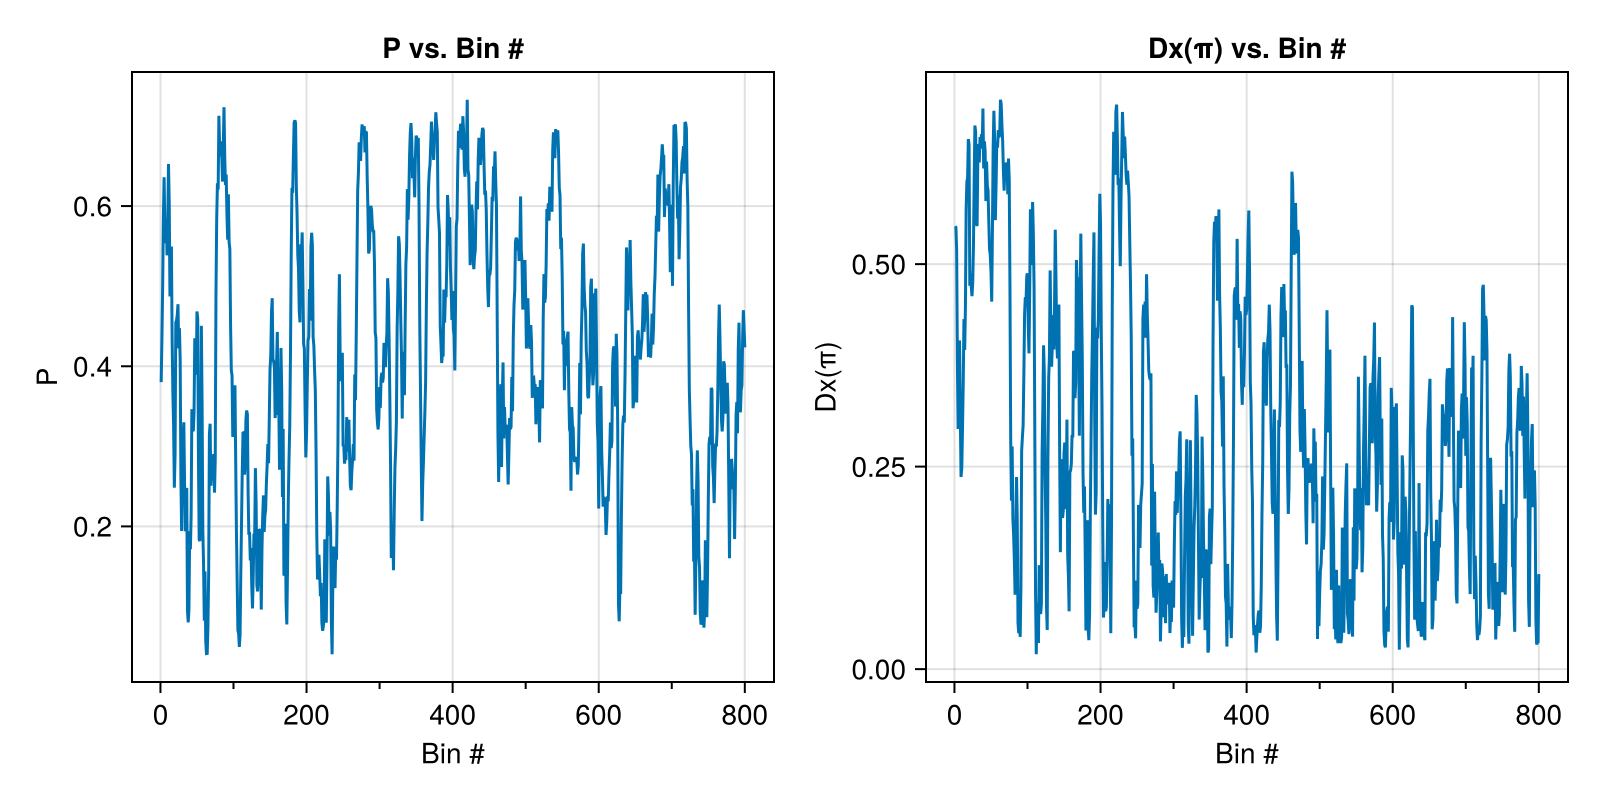

In [37]:
i = 35
print(ungrouped_data[i, :])
generate_mctime_plot(i)

In [27]:
task_no = "21"
file = h5open("../jobs/" * jobname * ".data/task00" * task_no * "/run0001.dump.h5")
spins = map(
    t -> [t[:data][1], t[:data][2], t[:data][3]],
    read(file, "simulation/spins")
)
spin_xs = map(v -> v[1], spins)
spin_ys = map(v -> v[2], spins)
spin_zs = map(v -> v[3], spins)
Lx, Ly = size(spins)
close(file)

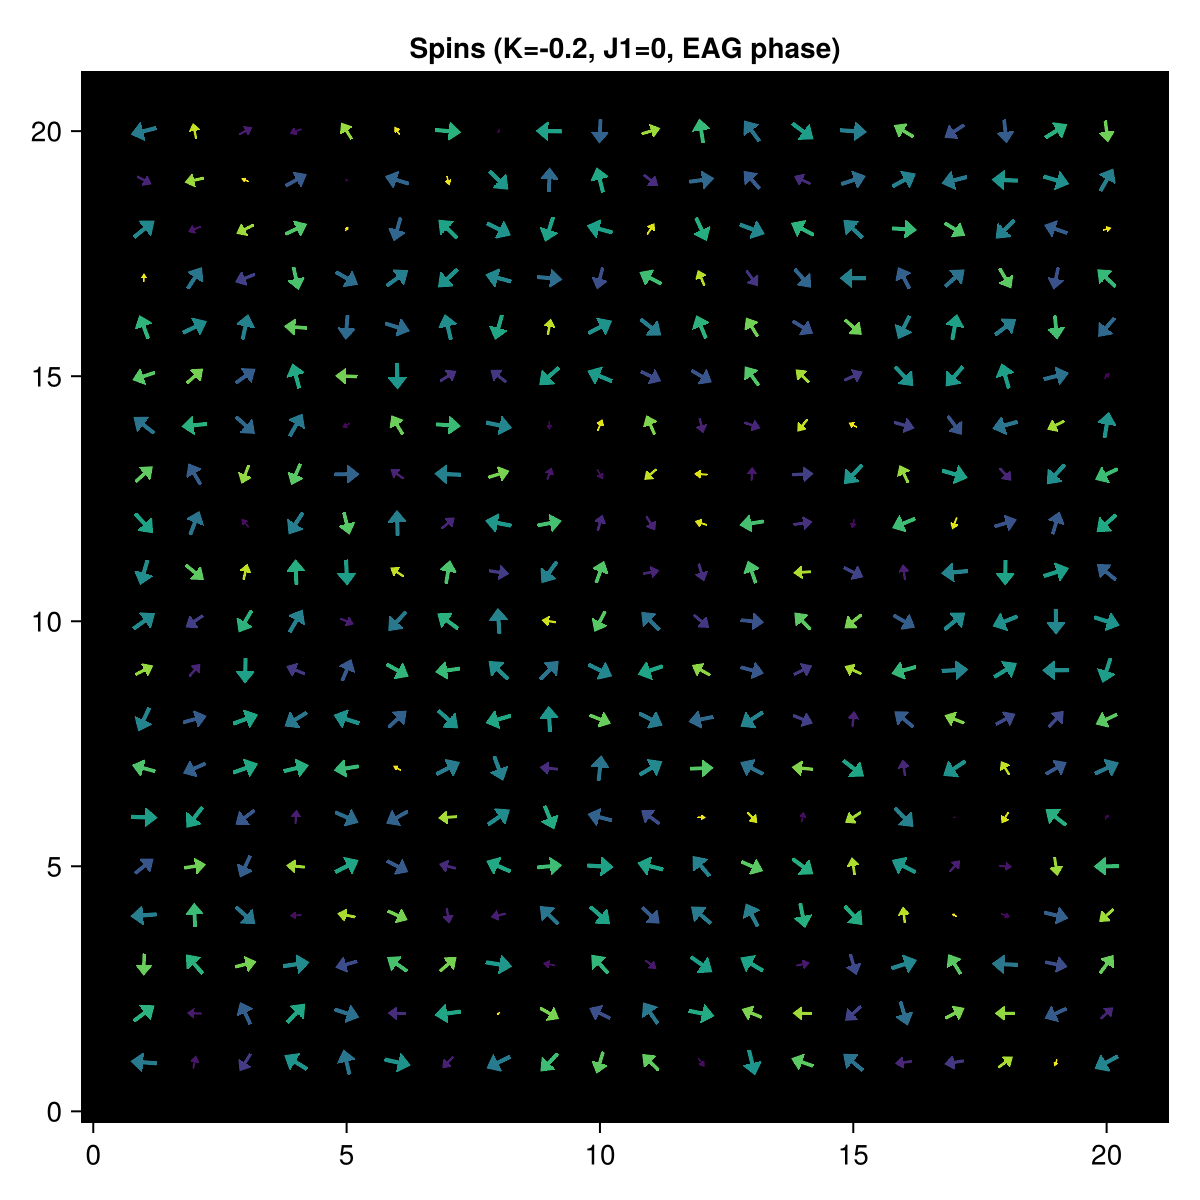

In [28]:
fig = Figure(size=(600, 600))
fig[1,1] = Axis(fig; title="Spins (K=-0.2, J1=0, EAG phase)", backgroundcolor="black")

strength = vec(spin_zs)
arrows2d!(1:Lx, 1:Ly, spin_xs, spin_ys, lengthscale=0.5, align=:center, color=strength)
fig

In [29]:
d = load("../jobs/$jobname.data/task$(lpad(i, 4, "0"))/spin-curr.jld")

ArgumentError: ArgumentError: No file exists at given path: ../jobs/small-sys.data/task0030/spin-curr.jld

In [30]:
sweep_no = 25000
Ps = d["sweep$sweep_no"]
Pys = map(v -> v[2], Ps)
Pzs = map(v -> v[3], Ps)
strength = vec(norm.(Ps))

fig = Figure(size=(600, 600))
fig[1,1] = Axis(fig; title="Spin Currents", backgroundcolor="black")
arrows2d!(1:Lx, 1:Ly, Pys, Pzs, lengthscale=0.5, align=:center, color=strength)
fig

UndefVarError: UndefVarError: `d` not defined in `Main`
Suggestion: check for spelling errors or missing imports.